## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import GloVe
from torchtext.vocab import GloVe
global_vectors = GloVe(name='840B', dim=300)

#tokenizer
import torchtext
from torchtext.data import get_tokenizer

## Data pre-pocessing

In [2]:
df = pd.read_csv('train.txt', delimiter='\t', header=None, names=["Label", "Review"])

#separating the labels into real/fake and positive/negative
df['Realness'] = df['Label'].str[:-8]
df['Sentiment'] = df['Label'].str[-8:]
df = df.drop('Label', axis=1)

# remove capitalized letters
#df['Review'] = df['Review'].str.lower()
#df['Review'] = tokenizer(df['Review'])
data = df.to_numpy()

X = data[:,0]
yr = data[:,1]
ys = data[:,2]
print(df)

#tokenizing
tokenizer = get_tokenizer("basic_english") 
X = [tokenizer(x) for x in X]

#getting max numer of tokens in one review
max_words = 0
tam = []
for x in X:
    tam.append(len(x))
    if len(x) > max_words:
        max_words = len(x)

print(f"max_words-->{max_words}")

#padding
X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]

#embeddings
X_emb = []
for token in X:
    # tokenize and use glove word embedding
    X_emb.append(np.array(global_vectors.get_vecs_by_tokens(token)))

X_emb = np.array(X_emb)
print(f"X_emb.shape-->{X_emb.shape}")

######### y's pre processing
for i in range(len(ys)):
    if ys[i] == "POSITIVE":
        ys[i] = 1
    else:
        ys[i] = 0

    if yr[i] == "TRUTHFUL":
        yr[i] = 1
    else:
        yr[i] = 0

ys = np.array(ys)
yr = np.array(yr)

                                                 Review   Realness Sentiment
0     The sheraton was a wonderful hotel! When me an...   TRUTHFUL  POSITIVE
1     We stayed at the Omni between Christmas and Ne...   TRUTHFUL  POSITIVE
2     I was REALLY looking forward to a nice relaxin...  DECEPTIVE  NEGATIVE
3     First let me say, I try not to be too critical...   TRUTHFUL  NEGATIVE
4     The Ambassador East Hotel is a terrible place ...  DECEPTIVE  NEGATIVE
...                                                 ...        ...       ...
1395  I stayed here for 5 nights last summer. I book...   TRUTHFUL  NEGATIVE
1396  Stayed here for 3 nights for a Bridgestone/Fir...   TRUTHFUL  POSITIVE
1397  I am staying here now and actually am compelle...   TRUTHFUL  NEGATIVE
1398  We stayed at this hotel with our two teenage d...   TRUTHFUL  NEGATIVE
1399  The rooms were beautiful! The staff was friend...  DECEPTIVE  POSITIVE

[1400 rows x 3 columns]
max_words-->864


X_emb.shape-->(1400, 864, 300)


In [3]:
print(f"type(X_emb)-->{type(X_emb)}")
print(f"type(ys)-->{type(ys)}")
print(f"type(yr)-->{type(yr)}\n")

print(f"X_emb.shape-->{X_emb.shape}")
print(f"ys.shape-->{ys.shape}")
print(f"yr.shape-->{yr.shape}")

type(X_emb)--><class 'numpy.ndarray'>
type(ys)--><class 'numpy.ndarray'>
type(yr)--><class 'numpy.ndarray'>

X_emb.shape-->(1400, 864, 300)
ys.shape-->(1400,)
yr.shape-->(1400,)


tam_min-->28
tam_MAX-->864
tam_avg-->168.855
tam_median-->168.855


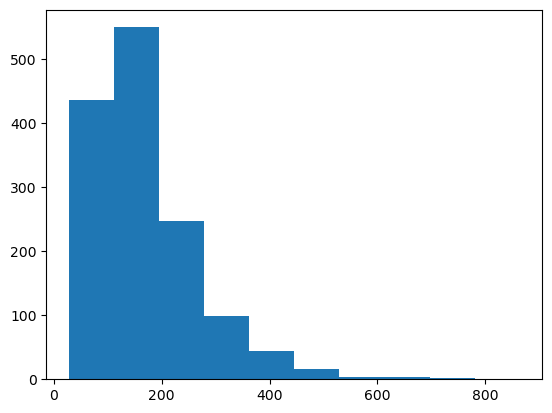

In [4]:
print(f"tam_min-->{np.min(tam)}")
print(f"tam_MAX-->{np.max(tam)}")
print(f"tam_avg-->{np.average(tam)}")
print(f"tam_median-->{np.average(tam)}")

# distribuição do numero de palavras por review
plt.hist(tam)
plt.show()

In [12]:
#save processed numpy arrays

np.save("./processed_train/X_emb.npy", X_emb)
np.save("./processed_train/ys.npy", ys)
np.save("./processed_train/yr.npy", yr)

In [13]:
# delete cache

del(global_vectors)